# Interpretability strategies for machinelearning language models for antibody sequences
## Results
Octave Malamoud CID 02504015

# Import

In [1]:

from transformers import (
    RobertaConfig,
    RobertaTokenizer,
    RobertaForMaskedLM,
    DataCollatorForLanguageModeling,
    TrainingArguments,
    Trainer,
)
from torch.utils.data import DataLoader
import numpy as np
import torch
from datasets import load_dataset,Dataset, DatasetDict
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import matplotlib.patches as mpatches
import umap
from scipy.spatial.distance import cosine,squareform
import blosum as bl
from datasets import load_from_disk
import tensorflow as tf
import re
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
from scipy.stats import pearsonr



c:\Users\omala\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Initialise the tokeniser
tokenizer = RobertaTokenizer.from_pretrained(
    "C:/Users/omala/OneDrive/Bureau/Imperial/Project/code/antibody-tokenizer/",
)

# Initialise the data collator, which is necessary for batching
collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=True, mlm_probability=0.15
)
torch.manual_seed(42)

In [3]:
# Load the models
model_large = RobertaForMaskedLM.from_pretrained(
    "D:/Thesis/antiberta_large"
)
model_large.config.output_hidden_states = True
model_medium = RobertaForMaskedLM.from_pretrained(
    "D:/Thesis/antiberta_medium"
)
model_medium.config.output_hidden_states = True
model_small = RobertaForMaskedLM.from_pretrained(
    "D:/Thesis/antiberta_small"
)
model_small.config.output_hidden_states = True
model = {"large":model_large, "medium":model_medium, "small":model_small}

In [4]:
# Load the tokenized dataset
tokenized_dataset = load_from_disk("D:/Thesis/antibody_tokenized_dataset12")

# Loss function evolution :


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


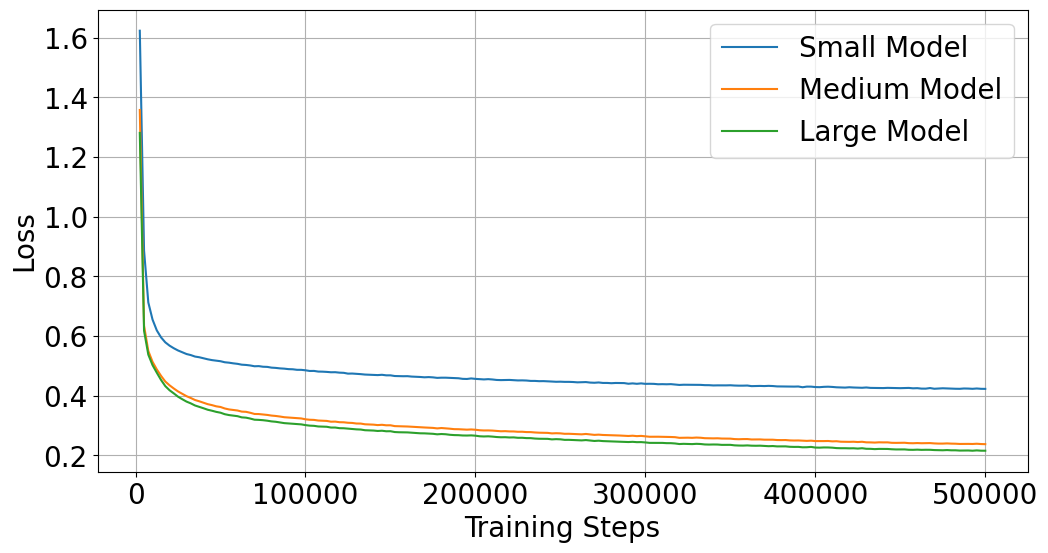

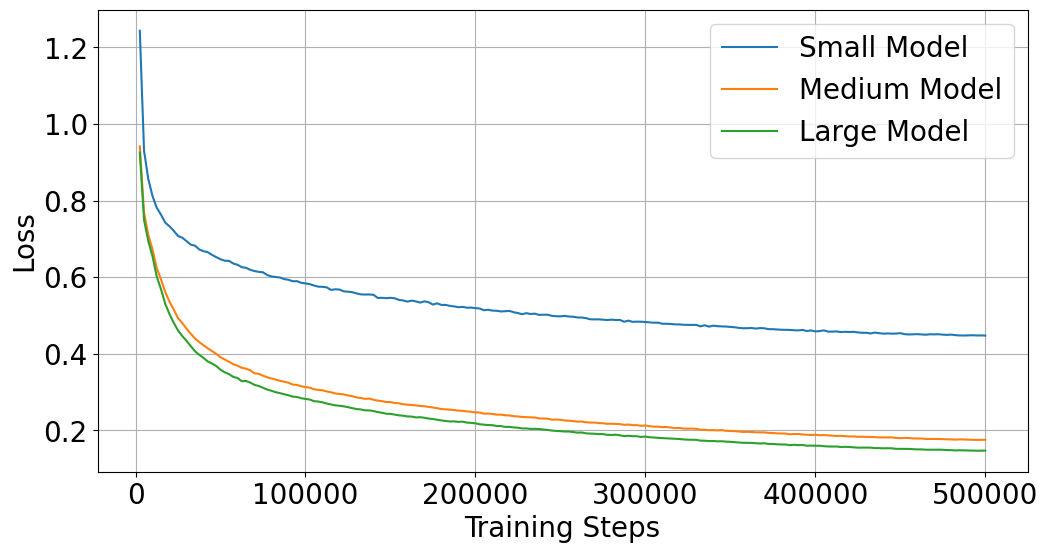

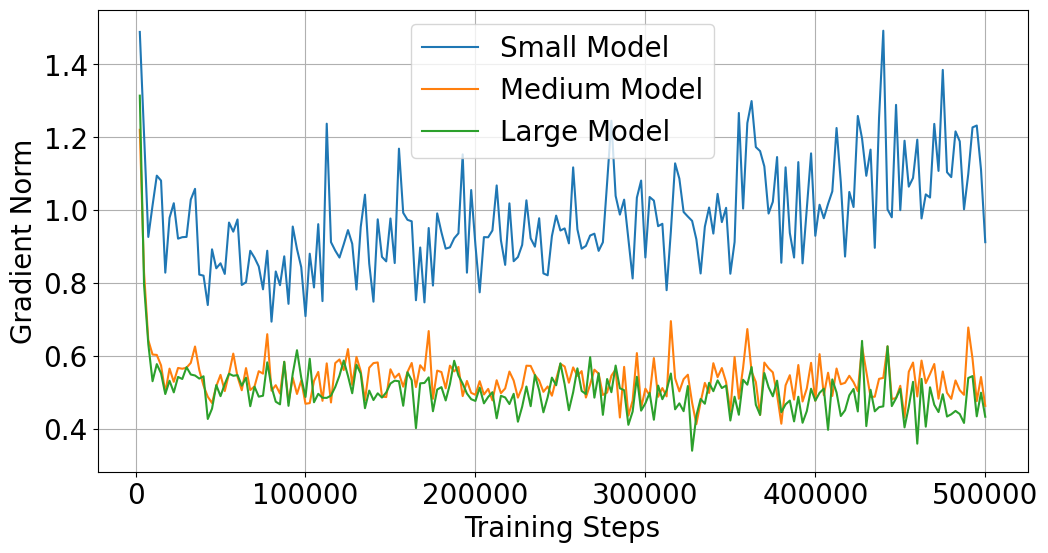

In [183]:


# Paths to the log directories for different model sizes
log_dirs = {
    'small': 'D:/Thesis/script_small_logs',
    'medium': 'D:/Thesis/script_medium_logs',
    'large': 'D:/Thesis/script_large_logs'
}

# Initialize dictionaries to hold metrics for each model
metrics = {
    'small': {'train_steps': [], 'train_losses': [], 'eval_steps': [], 'eval_losses': [], 'grad_norm': [],  'runtime': []},
    'medium': {'train_steps': [], 'train_losses': [], 'eval_steps': [], 'eval_losses': [], 'grad_norm': [],  'runtime': []},
    'large': {'train_steps': [], 'train_losses': [], 'eval_steps': [], 'eval_losses': [], 'grad_norm': [],  'runtime': []}
}

# Function to process logs and extract metrics
def process_logs(log_dir, model_size):
    for file_name in os.listdir(log_dir):
        file_path = os.path.join(log_dir, file_name)
        
        # Check if the file is an event file
        if file_name.startswith("events.out.tfevents"):
            # Iterate over the events in the file
            for event in tf.compat.v1.train.summary_iterator(file_path):
                metrics[model_size]['runtime'].append(event.wall_time)
                for value in event.summary.value:
                    if value.tag.lower() == "train/loss":
                        metrics[model_size]['train_steps'].append(event.step)
                        metrics[model_size]['train_losses'].append(value.simple_value)
                    elif value.tag.lower() == "eval/loss":
                        metrics[model_size]['eval_steps'].append(event.step)
                        metrics[model_size]['eval_losses'].append(value.simple_value)
                    elif value.tag.lower() == "train/grad_norm":
                        metrics[model_size]['grad_norm'].append(value.simple_value)


# Process logs for each model size
for model_size, log_dir in log_dirs.items():
    process_logs(log_dir, model_size)

# Plotting function to compare metrics
def plot_metrics(metric_name, ylabel):
    plt.figure(figsize=(12, 6))
    for model_size in metrics:
        if len(metrics[model_size][metric_name]) > 0:
            steps = metrics[model_size]['train_steps'] if 'train' in metric_name else metrics[model_size]['eval_steps']
            plt.plot(steps, metrics[model_size][metric_name], label=f"{model_size.capitalize()} Model")
    plt.xlabel('Training Steps', fontsize=20)
    plt.ylabel(ylabel, fontsize=20)
    plt.yticks(fontsize=20)
    plt.xticks(fontsize=20)
    plt.legend(fontsize=20)
    plt.grid(True)
    plt.show()

# Plot comparison for each metric
plot_metrics('train_losses', 'Loss')
plot_metrics('eval_losses', 'Loss')
plot_metrics('grad_norm', 'Gradient Norm')


# Embeddings of tokens by average

## setup


In [242]:
#Extract embeddings

model_size = "large"
embeddings = []
f_embeddings = []
test_subset = tokenized_dataset["test"]["input_ids"][-1000:]
tensor_test_subset = torch.tensor(test_subset)
for i in range(0, 1000, 8):  # Batch size of 8
        batch = tensor_test_subset[i:i+8]
        # Convert to dictionary of tensors and move to device
        
        outputs = model[model_size](batch)
        hidden_states = outputs.hidden_states
        embeddings.append(hidden_states[-1].detach().numpy())
        f_embeddings.append(hidden_states[0].detach().numpy())

embeddings = np.concatenate(embeddings, axis=0)
f_embeddings = np.concatenate(f_embeddings, axis=0)
print(embeddings.shape,f_embeddings.shape)

(1000, 150, 768) (1000, 150, 768)


In [243]:
# Flatten the embeddings and associate each position with its corresponding amino acid
amino_acid_to_embeddings = {}
f_amino_acid_to_embeddings = {}
for seq_index, seq in enumerate(test_subset):
    for pos_index, amino_acid in enumerate(seq):
        if amino_acid not in amino_acid_to_embeddings:
            amino_acid_to_embeddings[amino_acid] = []
            f_amino_acid_to_embeddings[amino_acid] = []
        amino_acid_to_embeddings[amino_acid].append(embeddings[seq_index, pos_index])
        f_amino_acid_to_embeddings[amino_acid].append(f_embeddings[seq_index, pos_index])
print(amino_acid_to_embeddings.keys(),
f_amino_acid_to_embeddings.keys())

dict_keys([0, 18, 22, 14, 8, 20, 10, 17, 19, 6, 5, 9, 24, 15, 11, 23, 13, 12, 7, 21, 16, 2, 1, 3]) dict_keys([0, 18, 22, 14, 8, 20, 10, 17, 19, 6, 5, 9, 24, 15, 11, 23, 13, 12, 7, 21, 16, 2, 1, 3])


In [244]:
averaged_dic_embeddings = {aa: np.mean(np.array(embeds), axis=0) for aa, embeds in amino_acid_to_embeddings.items()}
f_averaged_dic_embeddings = {aa: np.mean(np.array(embeds), axis=0) for aa, embeds in f_amino_acid_to_embeddings.items()}
print(averaged_dic_embeddings.keys())
vocab = {
  "<s>": 0,
  "<pad>": 1,
  "</s>": 2,
  "<unk>": 3,
  "<mask>": 4,
  "A": 5,
  "C": 6,
  "D": 7,
  "E": 8,
  "F": 9,
  "G": 10,
  "H": 11,
  "I": 12,
  "K": 13,
  "L": 14,
  "M": 15,
  "N": 16,
  "P": 17,
  "Q": 18,
  "R": 19,
  "S": 20,
  "T": 21,
  "V": 22,
  "W": 23,
  "Y": 24
}
# Create a new dictionary to hold the updated mappings
new_averaged_dic_embeddings = {}
f_new_averaged_dic_embeddings = {}
# Iterate over a copy of the original dictionary's keys
for key in list(averaged_dic_embeddings.keys()):
    for char, index in vocab.items():
        if key == index :
            new_averaged_dic_embeddings[char] = averaged_dic_embeddings.pop(key)
            f_new_averaged_dic_embeddings[char] = f_averaged_dic_embeddings.pop(key)
new_averaged_dic_embeddings.keys()




dict_keys([0, 18, 22, 14, 8, 20, 10, 17, 19, 6, 5, 9, 24, 15, 11, 23, 13, 12, 7, 21, 16, 2, 1, 3])


dict_keys(['<s>', 'Q', 'V', 'L', 'E', 'S', 'G', 'P', 'R', 'C', 'A', 'F', 'Y', 'M', 'H', 'W', 'K', 'I', 'D', 'T', 'N', '</s>', '<pad>', '<unk>'])

In [245]:
amino_acids = list(new_averaged_dic_embeddings.keys())
embeddings_avg = np.array(list(new_averaged_dic_embeddings.values()))
f_embeddings_avg = np.array(list(f_new_averaged_dic_embeddings.values()))
f_embeddings_avg.shape

(24, 768)

## With special

### Last layer

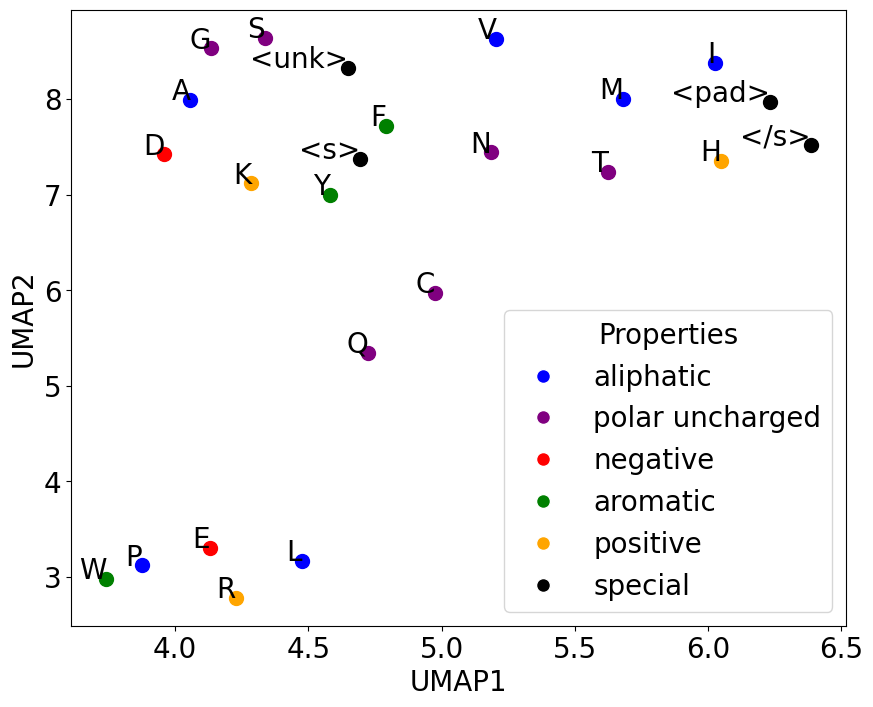

In [252]:
tsne = TSNE(n_components=2, perplexity=5, n_iter=3000, random_state=42)
tsne_results = tsne.fit_transform(embeddings_avg)

umap_reducer = umap.UMAP(n_components=2, n_neighbors=5, min_dist=0.001)
umap_results = umap_reducer.fit_transform(embeddings_avg)

amino_acid_properties = {
    "<s>": "special",
    "<pad>": "special",
    "</s>": "special",
    "<unk>": "special",
    "<mask>": "special",
    "A": "aliphatic",      # Alanine
    "C": "polar uncharged",# Cysteine
    "D": "negative",       # Aspartic acid
    "E": "negative",       # Glutamic acid
    "F": "aromatic",       # Phenylalanine
    "G": "polar uncharged",      # Glycine
    "H": "positive",       # Histidine
    "I": "aliphatic",      # Isoleucine
    "K": "positive",       # Lysine
    "L": "aliphatic",      # Leucine
    "M": "aliphatic",      # Methionine
    "N": "polar uncharged",# Asparagine
    "P": "aliphatic",      # Proline
    "Q": "polar uncharged",# Glutamine
    "R": "positive",       # Arginine
    "S": "polar uncharged",# Serine
    "T": "polar uncharged",# Threonine
    "V": "aliphatic",      # Valine
    "W": "aromatic",       # Tryptophan
    "Y": "aromatic"        # Tyrosine
}
property_colors = {'aliphatic': 'blue', 'polar uncharged': 'purple', 'negative': 'red', 'aromatic': 'green', 'positive': 'orange','special':'black'}
legend_elements = [mpatches.Patch(color=color, label=key) for key, color in property_colors.items()]

# Visualization
# plt.figure(figsize=(10, 8))
# for i, label in enumerate(amino_acids):
#     x, y = tsne_results[i, :]
#     plt.scatter(x, y, color=property_colors[amino_acid_properties[label]],s=100)
#     plt.text(x, y, label, fontsize=20, ha='right')
# plt.xlabel('Dimension 1', fontsize=20)
# plt.ylabel('Dimension 2', fontsize=20)
# plt.yticks(fontsize=20)
# plt.xticks(fontsize=20)
# plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=property_colors[prop], markersize=10, label=prop) for prop in property_colors], title="Properties",fontsize = 20, title_fontsize = 20)    
# plt.show()
plt.figure(figsize=(10, 8))
for i, label in enumerate(amino_acids):
    x, y = umap_results[i, :]
    plt.scatter(x, y, color=property_colors[amino_acid_properties[label]],s=100)
    plt.text(x, y, label, fontsize=20, ha='right')
plt.xlabel('UMAP1', fontsize=20)
plt.ylabel('UMAP2', fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=property_colors[prop], markersize=10, label=prop) for prop in property_colors], title="Properties",fontsize = 20, title_fontsize = 20)    
plt.show()


### First layer

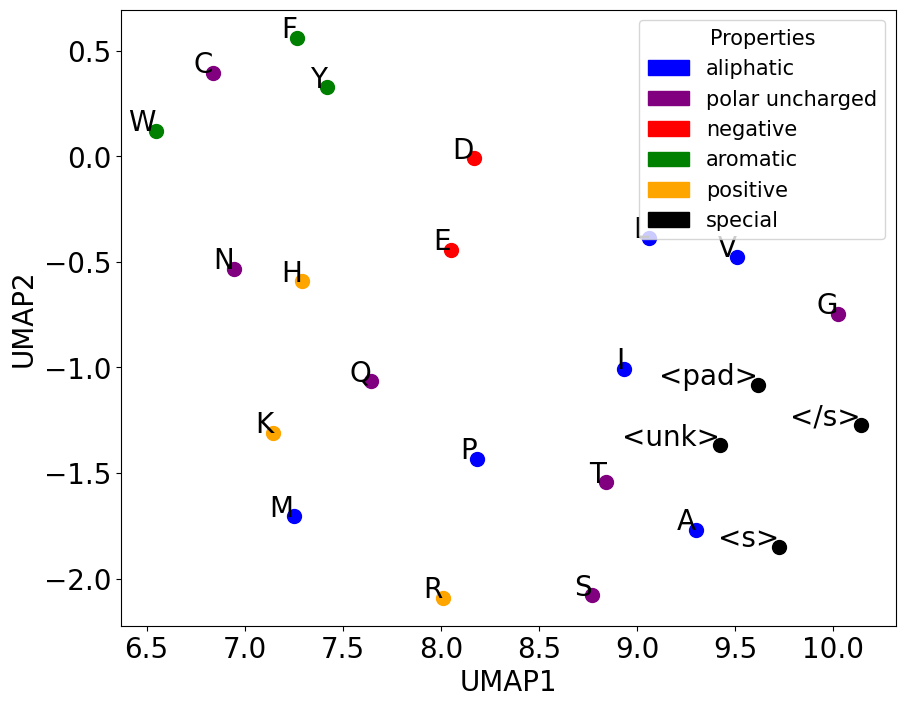

In [253]:
tsne = TSNE(n_components=2, perplexity=5, n_iter=3000, random_state=42)
tsne_results = tsne.fit_transform(f_embeddings_avg)

umap_reducer = umap.UMAP(n_components=2, n_neighbors=5, min_dist=0.001)
umap_results = umap_reducer.fit_transform(f_embeddings_avg)

amino_acid_properties = {
    "<s>": "special",
    "<pad>": "special",
    "</s>": "special",
    "<unk>": "special",
    "<mask>": "special",
    "A": "aliphatic",      # Alanine
    "C": "polar uncharged",# Cysteine
    "D": "negative",       # Aspartic acid
    "E": "negative",       # Glutamic acid
    "F": "aromatic",       # Phenylalanine
    "G": "polar uncharged",      # Glycine
    "H": "positive",       # Histidine
    "I": "aliphatic",      # Isoleucine
    "K": "positive",       # Lysine
    "L": "aliphatic",      # Leucine
    "M": "aliphatic",      # Methionine
    "N": "polar uncharged",# Asparagine
    "P": "aliphatic",      # Proline
    "Q": "polar uncharged",# Glutamine
    "R": "positive",       # Arginine
    "S": "polar uncharged",# Serine
    "T": "polar uncharged",# Threonine
    "V": "aliphatic",      # Valine
    "W": "aromatic",       # Tryptophan
    "Y": "aromatic"        # Tyrosine
}
property_colors = {'aliphatic': 'blue', 'polar uncharged': 'purple', 'negative': 'red', 'aromatic': 'green', 'positive': 'orange','special':'black'}
legend_elements = [mpatches.Patch(color=color, label=key) for key, color in property_colors.items()]

# # Visualization
# plt.figure(figsize=(10, 8))
# for i, label in enumerate(amino_acids):
#     x, y = tsne_results[i, :]
#     plt.scatter(x, y,color = property_colors[amino_acid_properties[label]])
#     plt.text(x, y, label, fontsize=15, ha='right')

# plt.xlabel('tsne_1')
# plt.ylabel('tsne_2')

# plt.legend(handles=legend_elements, title='Properties')
# plt.show()
plt.figure(figsize=(10, 8))
for i, label in enumerate(amino_acids):
    x, y = umap_results[i, :]
    plt.scatter(x, y, color=property_colors[amino_acid_properties[label]],s=100)
    plt.text(x, y, label, fontsize=20, ha='right')
plt.xlabel('UMAP1', fontsize=20)
plt.ylabel('UMAP2', fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.legend(handles=legend_elements, title="Properties",fontsize = 15, title_fontsize = 15)    
plt.show()


## No special

### Last layer

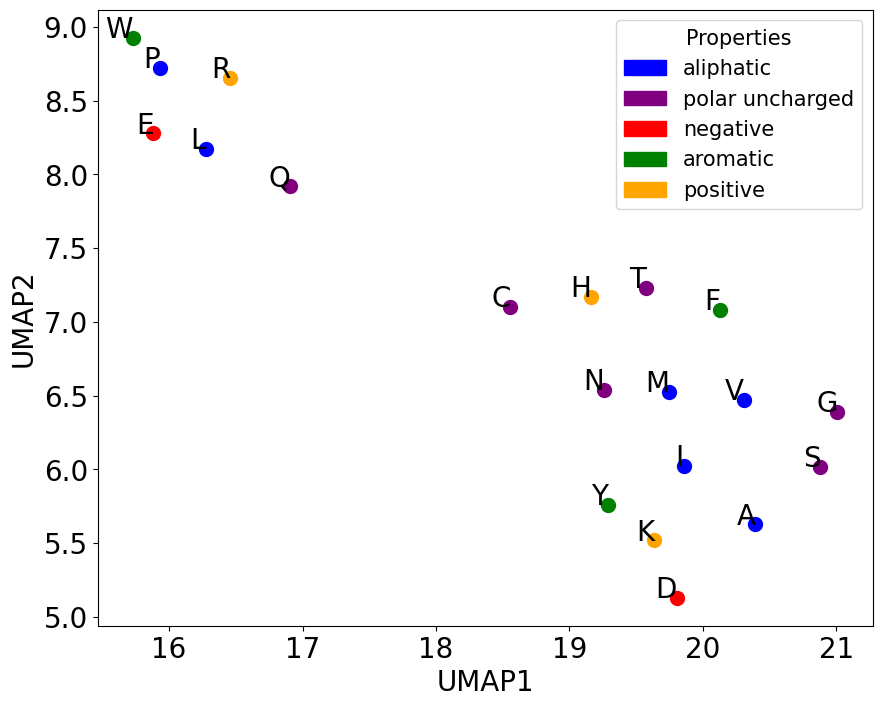

In [246]:
no_special = {k: v for k, v in new_averaged_dic_embeddings.items() if k not in ['<s>', '<pad>', '</s>', '<unk>', '<mask>']}
no_special_amino_acids = list(no_special.keys())
no_special_embeddings_avg = np.array(list(no_special.values()))

tsne = TSNE(n_components=2, perplexity=5, n_iter=3000)
tsne_results = tsne.fit_transform(no_special_embeddings_avg)

umap_reducer = umap.UMAP(n_components=2, n_neighbors=5, min_dist=0.001)
umap_results = umap_reducer.fit_transform(no_special_embeddings_avg)

no_special_amino_acid_properties = {
    "A": "aliphatic",      # Alanine
    "C": "polar uncharged",# Cysteine
    "D": "negative",       # Aspartic acid
    "E": "negative",       # Glutamic acid
    "F": "aromatic",       # Phenylalanine
    "G": "polar uncharged",      # Glycine
    "H": "positive",       # Histidine
    "I": "aliphatic",      # Isoleucine
    "K": "positive",       # Lysine
    "L": "aliphatic",      # Leucine
    "M": "aliphatic",      # Methionine
    "N": "polar uncharged",# Asparagine
    "P": "aliphatic",      # Proline
    "Q": "polar uncharged",# Glutamine
    "R": "positive",       # Arginine
    "S": "polar uncharged",# Serine
    "T": "polar uncharged",# Threonine
    "V": "aliphatic",      # Valine
    "W": "aromatic",       # Tryptophan
    "Y": "aromatic"        # Tyrosine
}
property_colors = {'aliphatic': 'blue', 'polar uncharged': 'purple', 'negative': 'red', 'aromatic': 'green', 'positive': 'orange'}
legend_elements = [mpatches.Patch(color=color, label=key) for key, color in property_colors.items()]

# # Visualization
# plt.figure(figsize=(10, 8))
# for i, label in enumerate(no_special_amino_acids):
#     x, y = tsne_results[i, :]
#     plt.scatter(x, y,color = property_colors[no_special_amino_acid_properties[label]])
#     plt.text(x, y, label, fontsize=15, ha='right')

# plt.xlabel('tsne_1')
# plt.ylabel('tsne_2')

# plt.legend(handles=legend_elements, title='Properties')
# plt.show()
plt.figure(figsize=(10, 8))
for i, label in enumerate(no_special_amino_acids):
    x, y = umap_results[i, :]
    plt.scatter(x, y, color=property_colors[amino_acid_properties[label]],s=100)
    plt.text(x, y, label, fontsize=20, ha='right')
plt.xlabel('UMAP1', fontsize=20)
plt.ylabel('UMAP2', fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.legend(handles=legend_elements, title="Properties",fontsize = 15, title_fontsize = 15)    
plt.show()


### First layer

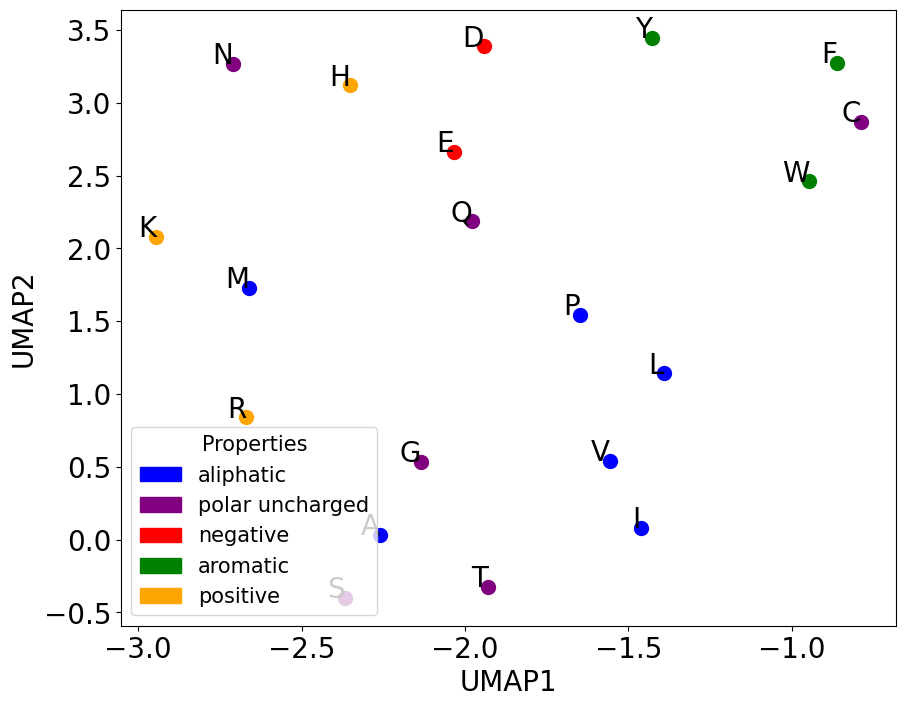

In [255]:
f_no_special = {k: v for k, v in f_new_averaged_dic_embeddings.items() if k not in ['<s>', '<pad>', '</s>', '<unk>', '<mask>']}
f_no_special_amino_acids = list(f_no_special.keys())
f_no_special_embeddings_avg = np.array(list(f_no_special.values()))

tsne = TSNE(n_components=2, perplexity=5, n_iter=3000, random_state=42)
tsne_results = tsne.fit_transform(f_no_special_embeddings_avg)

umap_reducer = umap.UMAP(n_components=2, n_neighbors=5, min_dist=0.001)
umap_results = umap_reducer.fit_transform(f_no_special_embeddings_avg)

no_special_amino_acid_properties = {
    "A": "aliphatic",      # Alanine
    "C": "polar uncharged",# Cysteine
    "D": "negative",       # Aspartic acid
    "E": "negative",       # Glutamic acid
    "F": "aromatic",       # Phenylalanine
    "G": "polar uncharged",      # Glycine
    "H": "positive",       # Histidine
    "I": "aliphatic",      # Isoleucine
    "K": "positive",       # Lysine
    "L": "aliphatic",      # Leucine
    "M": "aliphatic",      # Methionine
    "N": "polar uncharged",# Asparagine
    "P": "aliphatic",      # Proline
    "Q": "polar uncharged",# Glutamine
    "R": "positive",       # Arginine
    "S": "polar uncharged",# Serine
    "T": "polar uncharged",# Threonine
    "V": "aliphatic",      # Valine
    "W": "aromatic",       # Tryptophan
    "Y": "aromatic"        # Tyrosine
}
property_colors = {'aliphatic': 'blue', 'polar uncharged': 'purple', 'negative': 'red', 'aromatic': 'green', 'positive': 'orange'}
legend_elements = [mpatches.Patch(color=color, label=key) for key, color in property_colors.items()]

# Visualization
# plt.figure(figsize=(10, 8))
# for i, label in enumerate(no_special_amino_acids):
#     x, y = tsne_results[i, :]
#     plt.scatter(x, y,color = property_colors[no_special_amino_acid_properties[label]])
#     plt.text(x, y, label, fontsize=15, ha='right')

# plt.xlabel('tsne_1')
# plt.ylabel('tsne_2')

# plt.legend(handles=legend_elements, title='Properties')
# plt.show()
plt.figure(figsize=(10, 8))
for i, label in enumerate(no_special_amino_acids):
    x, y = umap_results[i, :]
    plt.scatter(x, y, color=property_colors[amino_acid_properties[label]],s=100)
    plt.text(x, y, label, fontsize=20, ha='right')
plt.xlabel('UMAP1', fontsize=20)
plt.ylabel('UMAP2', fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.legend(handles=legend_elements, title="Properties",fontsize = 15, title_fontsize = 15)    
plt.show()


# Token embeddings from model

In [197]:
# Extract embeddings
model["large"].eval()
word_token_embeddings_large = model["large"].roberta.embeddings.word_embeddings.weight.data.cpu().numpy()
model["medium"].eval()
word_token_embeddings_medium = model["medium"].roberta.embeddings.word_embeddings.weight.data.cpu().numpy()
model["small"].eval()
word_token_embeddings_small = model["small"].roberta.embeddings.word_embeddings.weight.data.cpu().numpy()
word_token_embeddings = {"large":word_token_embeddings_large, "medium":word_token_embeddings_medium, "small":word_token_embeddings_small}
# token_embeddings = token_embeddings / np.linalg.norm(token_embeddings, axis=1)[:, None]
word_token_embeddings["large"].shape

(25, 768)

## With special

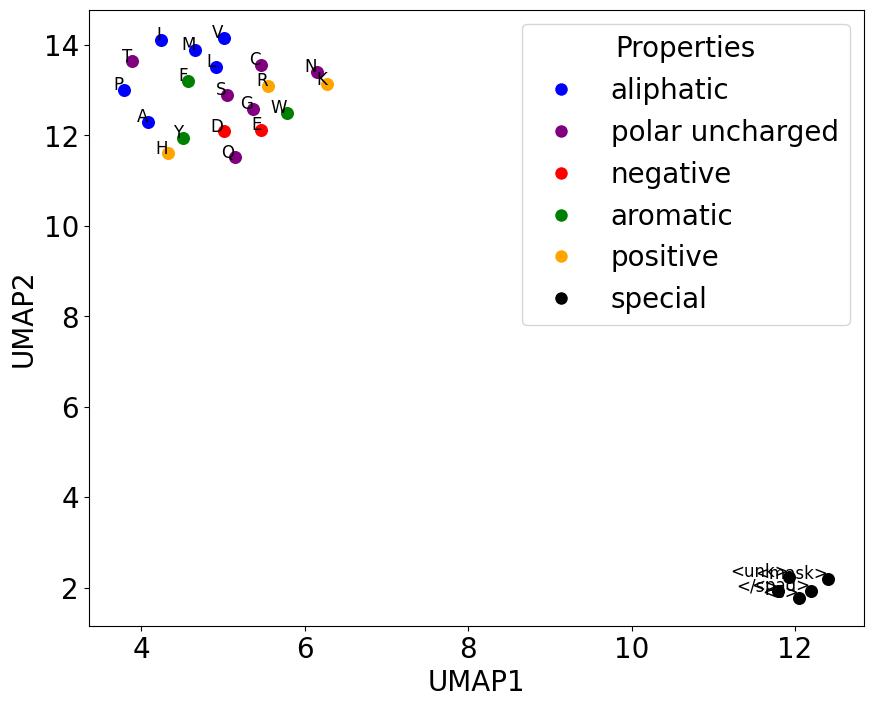

In [186]:
model_size = "large"
amino_acid_properties = {
    "<s>": "special",
    "<pad>": "special",
    "</s>": "special",
    "<unk>": "special",
    "<mask>": "special",
    "A": "aliphatic",      # Alanine
    "C": "polar uncharged",# Cysteine
    "D": "negative",       # Aspartic acid
    "E": "negative",       # Glutamic acid
    "F": "aromatic",       # Phenylalanine
    "G": "polar uncharged",      # Glycine
    "H": "positive",       # Histidine
    "I": "aliphatic",      # Isoleucine
    "K": "positive",       # Lysine
    "L": "aliphatic",      # Leucine
    "M": "aliphatic",      # Methionine
    "N": "polar uncharged",# Asparagine
    "P": "aliphatic",      # Proline
    "Q": "polar uncharged",# Glutamine
    "R": "positive",       # Arginine
    "S": "polar uncharged",# Serine
    "T": "polar uncharged",# Threonine
    "V": "aliphatic",      # Valine
    "W": "aromatic",       # Tryptophan
    "Y": "aromatic"        # Tyrosine
}
property_colors = {'aliphatic': 'blue', 'polar uncharged': 'purple', 'negative': 'red', 'aromatic': 'green', 'positive': 'orange', 'special': 'black'}
tsne = TSNE(n_components=2,n_iter=3000, random_state=42, perplexity=2)
tsne_results = tsne.fit_transform(word_token_embeddings[model_size])

# UMAP
umap_reducer = umap.UMAP(n_neighbors=5, min_dist=0.001, metric='cosine')
umap_results = umap_reducer.fit_transform(word_token_embeddings[model_size])
amino_acids = list(amino_acid_properties.keys())
# Function to plot embeddings
def plot_embeddings(results):
    plt.figure(figsize=(10, 8))
    for i, label in enumerate(amino_acids):
        x, y = results[i, :]
        plt.scatter(x, y, color=property_colors[amino_acid_properties[label]],s=70)
        plt.text(x, y, label, fontsize=12, ha='right')
    plt.xlabel('UMAP1', fontsize=20)
    plt.ylabel('UMAP2', fontsize=20)
    plt.yticks(fontsize=20)
    plt.xticks(fontsize=20)
    plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=property_colors[prop], markersize=10, label=prop) for prop in property_colors], title="Properties",fontsize = 20, title_fontsize = 20)
    plt.show()

# Plot t-SNE results
# plot_embeddings(tsne_results)

# Plot UMAP results
plot_embeddings(umap_results )

## Without special

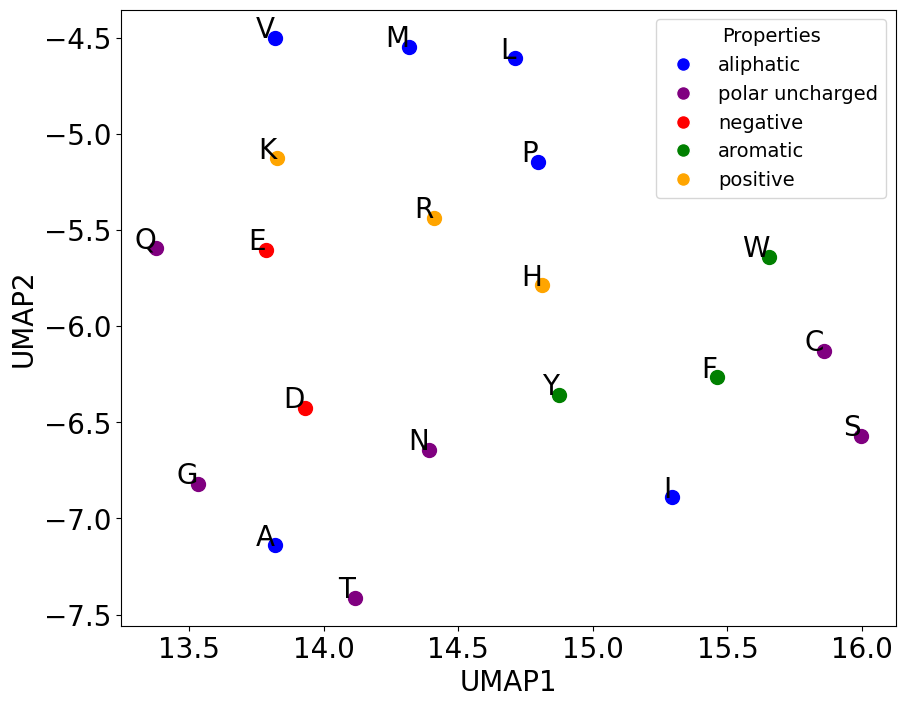

In [241]:
model_size = "small"
no_special_amino_acid_properties = {
    "A": "aliphatic",      # Alanine
    "C": "polar uncharged",# Cysteine
    "D": "negative",       # Aspartic acid
    "E": "negative",       # Glutamic acid
    "F": "aromatic",       # Phenylalanine
    "G": "polar uncharged",      # Glycine
    "H": "positive",       # Histidine
    "I": "aliphatic",      # Isoleucine
    "K": "positive",       # Lysine
    "L": "aliphatic",      # Leucine
    "M": "aliphatic",      # Methionine
    "N": "polar uncharged",# Asparagine
    "P": "aliphatic",      # Proline
    "Q": "polar uncharged",# Glutamine
    "R": "positive",       # Arginine
    "S": "polar uncharged",# Serine
    "T": "polar uncharged",# Threonine
    "V": "aliphatic",      # Valine
    "W": "aromatic",       # Tryptophan
    "Y": "aromatic"        # Tyrosine
}
no_special_amino_acids = list(no_special_amino_acid_properties.keys())
property_colors = {'aliphatic': 'blue', 'polar uncharged': 'purple', 'negative': 'red', 'aromatic': 'green', 'positive': 'orange'}
tsne = TSNE(n_components=2, random_state=42, perplexity=2,n_iter=30000)
tsne_results = tsne.fit_transform(word_token_embeddings[model_size][5:])
# UMAP
umap_reducer = umap.UMAP(n_neighbors=5, min_dist=0.01, metric='cosine')
umap_results = umap_reducer.fit_transform(word_token_embeddings[model_size][5:])

# Function to plot embeddings
def plot_embeddings(results):
    plt.figure(figsize=(10, 8))
    for i, label in enumerate(no_special_amino_acids):
        x, y = results[i, :]
        plt.scatter(x, y, color=property_colors[no_special_amino_acid_properties[label]], s=100)
        plt.text(x, y, label, fontsize=20, ha='right')
    plt.xlabel('UMAP1', fontsize=20)
    plt.ylabel('UMAP2', fontsize=20)
    plt.yticks(fontsize=20)
    plt.xticks(fontsize=20)
    plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=property_colors[prop], markersize=10, label=prop) for prop in property_colors], title="Properties",fontsize = 14, title_fontsize = 14)
    plt.show()

# Plot t-SNE results
# plot_embeddings(tsne_results)

# Plot UMAP results
plot_embeddings(umap_results)

# Token embeddings 1 token sequences


## Setup

In [265]:
sequences = Dataset.from_dict({"sequence": ["A", "C", "D", "E", "F", "G", "H", "I", "K", "L", "M", "N", "P", "Q", "R", "S", "T", "V", "W", "Y"]})
def tokenize_function(examples):
    return tokenizer(
        examples["sequence"],
        padding="max_length",
        truncation=True,
        max_length=150,
        return_special_tokens_mask=True,
    )

dataset_dict = DatasetDict({
    "test": sequences
})
# Tokenize the datasets
one_tokenized_dataset = dataset_dict.map(tokenize_function, batched=True, remove_columns=["sequence"])

# Display the tokenized dataset
print(one_tokenized_dataset)

one_test_subset = one_tokenized_dataset["test"]["input_ids"]
one_test_subset = torch.tensor(one_test_subset)

Map: 100%|██████████| 20/20 [00:00<00:00, 475.08 examples/s]

DatasetDict({
    test: Dataset({
        features: ['input_ids', 'special_tokens_mask', 'attention_mask'],
        num_rows: 20
    })
})


In [266]:
model_size = "large"
one_token_embeddings = {}
one_f_token_embeddings = {}
model[model_size].eval()
token_embeddings = []
f_token_embeddings = []
outputs = model[model_size](one_test_subset)
hidden_states = outputs.hidden_states
token_embeddings.append(hidden_states[-1].detach().numpy())  
f_token_embeddings.append(hidden_states[0].detach().numpy()) 
token_embeddings = np.concatenate(token_embeddings, axis=0)
f_token_embeddings = np.concatenate(f_token_embeddings, axis=0)
token_embeddings = token_embeddings[:,0,:]
f_token_embeddings = f_token_embeddings[:,0,:]
one_token_embeddings[model_size] = token_embeddings
one_f_token_embeddings[model_size] = f_token_embeddings

print(one_token_embeddings[model_size].shape,one_f_token_embeddings[model_size].shape)

(20, 768) (20, 768)


## Last layer

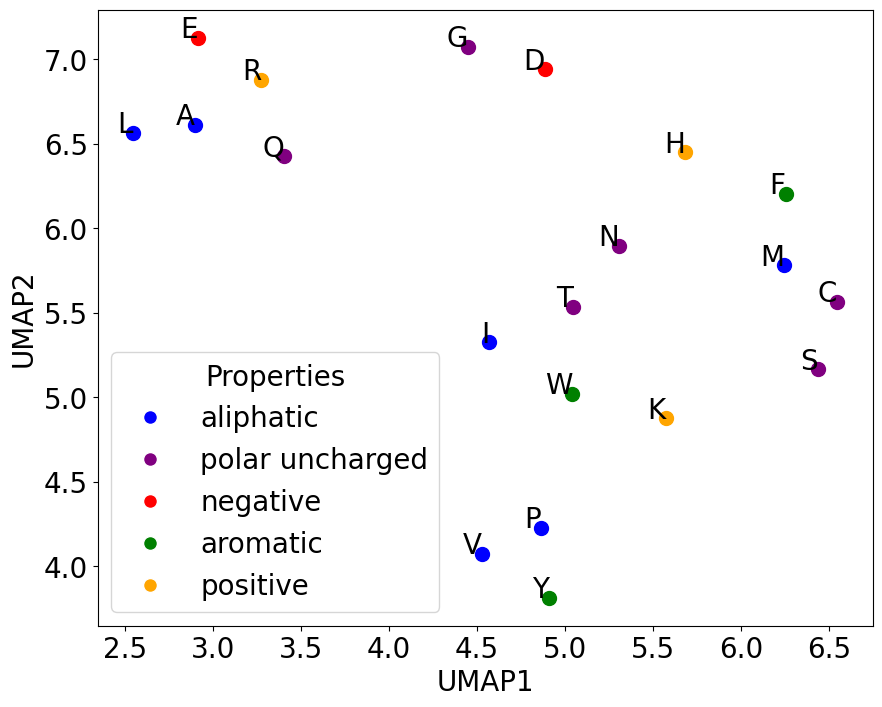

In [278]:
model_size = "large"
no_special_amino_acid_properties = {
    "A": "aliphatic",      # Alanine
    "C": "polar uncharged",# Cysteine
    "D": "negative",       # Aspartic acid
    "E": "negative",       # Glutamic acid
    "F": "aromatic",       # Phenylalanine
    "G": "polar uncharged",      # Glycine
    "H": "positive",       # Histidine
    "I": "aliphatic",      # Isoleucine
    "K": "positive",       # Lysine
    "L": "aliphatic",      # Leucine
    "M": "aliphatic",      # Methionine
    "N": "polar uncharged",# Asparagine
    "P": "aliphatic",      # Proline
    "Q": "polar uncharged",# Glutamine
    "R": "positive",       # Arginine
    "S": "polar uncharged",# Serine
    "T": "polar uncharged",# Threonine
    "V": "aliphatic",      # Valine
    "W": "aromatic",       # Tryptophan
    "Y": "aromatic"        # Tyrosine
}
no_special_amino_acids = list(no_special_amino_acid_properties.keys())
property_colors = {'aliphatic': 'blue', 'polar uncharged': 'purple', 'negative': 'red', 'aromatic': 'green', 'positive': 'orange'}
tsne = TSNE(n_components=2, random_state=2024, perplexity=3,n_iter=3000)
tsne_results = tsne.fit_transform(one_token_embeddings[model_size])

# UMAP
umap_reducer = umap.UMAP(n_neighbors=5, min_dist=0.001, metric='cosine')
umap_results = umap_reducer.fit_transform(one_token_embeddings[model_size])

# Function to plot embeddings
def plot_embeddings(results):
    plt.figure(figsize=(10, 8))
    for i, label in enumerate(no_special_amino_acids):
        x, y = results[i, :]
        plt.scatter(x, y, color=property_colors[no_special_amino_acid_properties[label]],s=100)
        plt.text(x, y, label, fontsize=20, ha='right')
    plt.xlabel('UMAP1', fontsize=20)
    plt.ylabel('UMAP2', fontsize=20)
    plt.yticks(fontsize=20)
    plt.xticks(fontsize=20)
    plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=property_colors[prop], markersize=10, label=prop) for prop in property_colors], title="Properties",fontsize = 20, title_fontsize = 20)    
    plt.show()
    

# Plot t-SNE results
# plot_embeddings(tsne_results, 't-SNE Projection of Amino Acid Embeddings')

# Plot UMAP results
plot_embeddings(umap_results)

## First layer

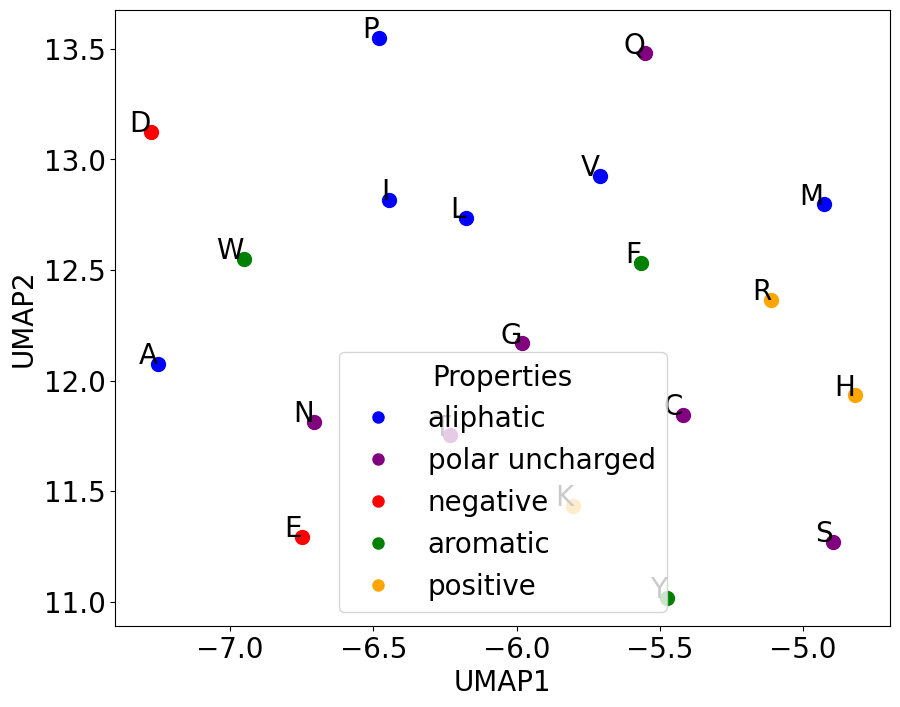

In [269]:
model_size = "large"
no_special_amino_acid_properties = {
    "A": "aliphatic",      # Alanine
    "C": "polar uncharged",# Cysteine
    "D": "negative",       # Aspartic acid
    "E": "negative",       # Glutamic acid
    "F": "aromatic",       # Phenylalanine
    "G": "polar uncharged",      # Glycine
    "H": "positive",       # Histidine
    "I": "aliphatic",      # Isoleucine
    "K": "positive",       # Lysine
    "L": "aliphatic",      # Leucine
    "M": "aliphatic",      # Methionine
    "N": "polar uncharged",# Asparagine
    "P": "aliphatic",      # Proline
    "Q": "polar uncharged",# Glutamine
    "R": "positive",       # Arginine
    "S": "polar uncharged",# Serine
    "T": "polar uncharged",# Threonine
    "V": "aliphatic",      # Valine
    "W": "aromatic",       # Tryptophan
    "Y": "aromatic"        # Tyrosine
}
no_special_amino_acids = list(no_special_amino_acid_properties.keys())
property_colors = {'aliphatic': 'blue', 'polar uncharged': 'purple', 'negative': 'red', 'aromatic': 'green', 'positive': 'orange'}
# tsne = TSNE(n_components=2, random_state=42, perplexity=2,n_iter=3000)
# tsne_results = tsne.fit_transform(one_f_token_embeddings[model_size])

# UMAP
umap_reducer = umap.UMAP(n_neighbors=5, min_dist=0.001, metric='cosine')
umap_results = umap_reducer.fit_transform(one_f_token_embeddings[model_size])

# Function to plot embeddings
def plot_embeddings(results):
    plt.figure(figsize=(10, 8))
    for i, label in enumerate(no_special_amino_acids):
        x, y = results[i, :]
        plt.scatter(x, y, color=property_colors[no_special_amino_acid_properties[label]],s=100)
        plt.text(x, y, label, fontsize=20, ha='right')
    plt.xlabel('UMAP1', fontsize=20)
    plt.ylabel('UMAP2', fontsize=20)
    plt.yticks(fontsize=20)
    plt.xticks(fontsize=20)
    plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=property_colors[prop], markersize=10, label=prop) for prop in property_colors], title="Properties",fontsize = 20, title_fontsize = 20)    
    plt.show()

# Plot t-SNE results
# plot_embeddings(tsne_results, 't-SNE Projection of Amino Acid Embeddings')

# Plot UMAP results
plot_embeddings(umap_results)

# Embeddings visualisation of V_FAM

## V_FAM family

In [59]:
dataset = pd.read_csv("D:/Thesis/dataset_12.csv")

In [60]:
# Extract V gene type using a function
def extract_v_gene_type(ighv_string):
    match = re.match(r"IGHV(\d+)-", ighv_string)
    if match:
        return f"V{match.group(1)}"
    else:
        return None

# Apply the function to get the V gene types
V_FAM = dataset["v_call"][-1000:]
V_FAM = V_FAM.reset_index(drop=True)
V_FAM = V_FAM.apply(extract_v_gene_type)

# Count the occurrences of each V gene type
counts = V_FAM.value_counts()
filter = V_FAM.isin(counts[counts >= 20].index)
# Filter V_FAM to keep only the V gene types with at least 20 occurrences
V_FAM = V_FAM[filter]

# Display the filtered counts
print(V_FAM.value_counts())


v_call
V3    663
V4    163
V1    140
V2     25
Name: count, dtype: int64


In [7]:
model_size = "large"
embeddings = []
f_embeddings = []
test_subset = tokenized_dataset["test"]["input_ids"][-1000:]
tensor_test_subset = torch.tensor(test_subset)
print(tensor_test_subset.shape)
for i in range(0, 1000, 8):  # Batch size of 8
        batch = tensor_test_subset[i:i+8]
        # Convert to dictionary of tensors and move to device
        
        outputs = model[model_size](batch)
        hidden_states = outputs.hidden_states
        embeddings.append(hidden_states[-1].detach().numpy())
        f_embeddings.append(hidden_states[0].detach().numpy())

embeddings = np.concatenate(embeddings, axis=0)
f_embeddings = np.concatenate(f_embeddings, axis=0)
embeddings = embeddings[filter]
f_embeddings = f_embeddings[filter]
print(embeddings.shape,f_embeddings.shape)

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


torch.Size([1000, 150])
(991, 150, 768) (991, 150, 768)


In [24]:
n_samples, seq_length, embedding_dim = embeddings.shape
average_embeddings = np.mean(embeddings, axis=1)
f_average_embeddings = np.mean(f_embeddings, axis=1)
batch_size = 500 
reducer= umap.UMAP(n_neighbors=5, min_dist=0.001, metric='cosine')
umap_embeddings3 = reducer.fit_transform(average_embeddings)
umap_df = pd.DataFrame(umap_embeddings3, columns=['UMAP1', 'UMAP2'])
umap_df["V_FAM"] = V_FAM.values
f_reducer= umap.UMAP(n_neighbors=5, min_dist=0.0001, metric='cosine')
f_umap_embeddings3 = reducer.fit_transform(f_average_embeddings)
f_umap_df = pd.DataFrame(f_umap_embeddings3, columns=['UMAP1', 'UMAP2'])
f_umap_df["V_FAM"] = V_FAM.values

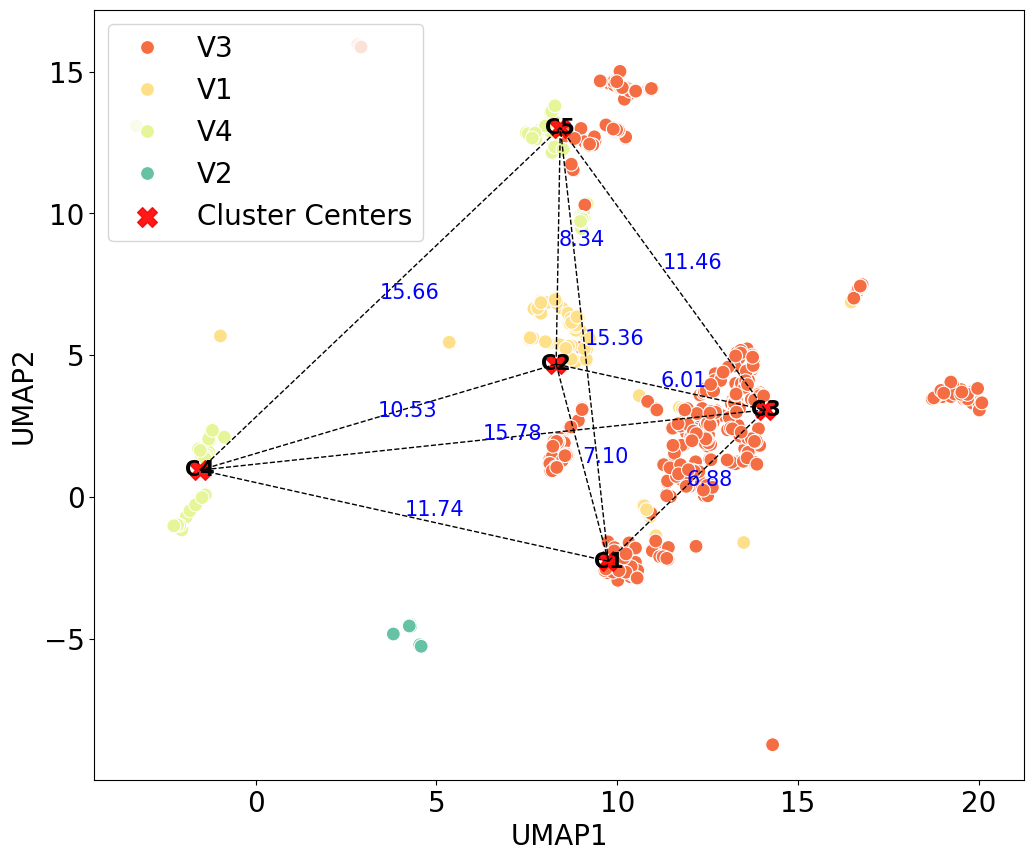

In [28]:
# Perform K-Means Clustering on the UMAP Embeddings
n_clusters = 5  # Adjust number of clusters as needed
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(umap_df[['UMAP1', 'UMAP2']])

# Get the cluster centers
cluster_centers = kmeans.cluster_centers_

# Get the labels for each data point
labels = kmeans.labels_

# Calculate pairwise distances between cluster centers
cluster_distances = pairwise_distances(cluster_centers, metric='euclidean')

# Plot UMAP with K-Means Clusters and Distances
plt.figure(figsize=(12, 10))

# Scatter plot for data points
sns.scatterplot(data=umap_df, x='UMAP1', y='UMAP2', hue='V_FAM', palette='Spectral', s=100)

# Scatter plot for cluster centers
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='red', s=200, alpha=0.9, marker='X', label='Cluster Centers')

# Annotate cluster centers with their indices
for i, center in enumerate(cluster_centers):
    plt.text(center[0], center[1], f'C{i+1}', color='black', fontsize=15, ha='center', va='center', weight='bold')

# Plot lines between cluster centers and annotate distances
for i in range(n_clusters):
    for j in range(i + 1, n_clusters):
        center_i = cluster_centers[i]
        center_j = cluster_centers[j]
        distance = cluster_distances[i, j]
        
        # Draw a line between cluster centers
        plt.plot([center_i[0], center_j[0]], [center_i[1], center_j[1]], 'k--', linewidth=1)
        
        # Annotate the line with the distance
        mid_x = (center_i[0] + center_j[0]) / 2
        mid_y = (center_i[1] + center_j[1]) / 2
        plt.text(mid_x, mid_y, f'{distance:.2f}', color='blue', fontsize=15)

# Add labels
plt.xlabel('UMAP1', fontsize=20)
plt.ylabel('UMAP2',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Display legend
plt.legend(loc='upper left', fontsize=20)
plt.show()


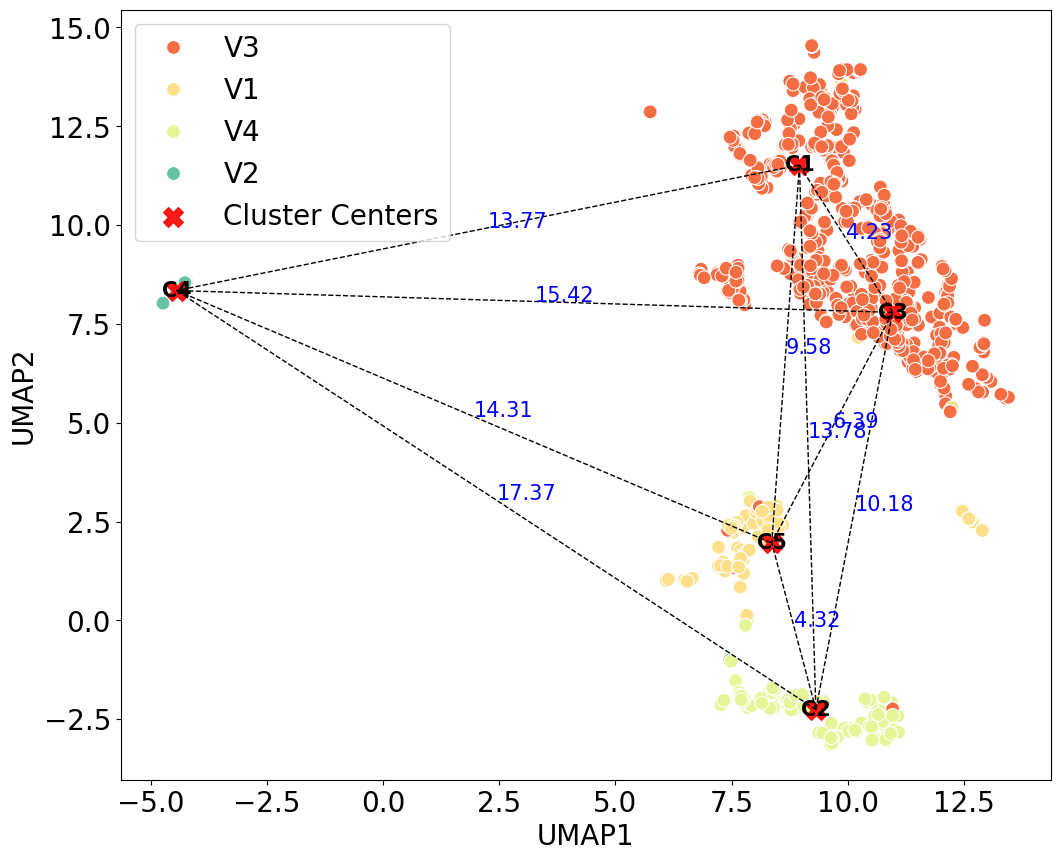

In [20]:


# Perform K-Means Clustering on the UMAP Embeddings
n_clusters = 5  # Adjust number of clusters as needed
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(f_umap_df[['UMAP1', 'UMAP2']])

# Get the cluster centers
cluster_centers = kmeans.cluster_centers_

# Get the labels for each data point
labels = kmeans.labels_

# Calculate pairwise distances between cluster centers
cluster_distances = pairwise_distances(cluster_centers, metric='euclidean')

# Plot UMAP with K-Means Clusters and Distances
plt.figure(figsize=(12, 10))

# Scatter plot for data points
sns.scatterplot(data=f_umap_df, x='UMAP1', y='UMAP2', hue='V_FAM', palette='Spectral', s=100)

# Scatter plot for cluster centers
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='red', s=200, alpha=0.9, marker='X', label='Cluster Centers')

# Annotate cluster centers with their indices
for i, center in enumerate(cluster_centers):
    plt.text(center[0], center[1], f'C{i+1}', color='black', fontsize=15, ha='center', va='center', weight='bold')

# Plot lines between cluster centers and annotate distances
for i in range(n_clusters):
    for j in range(i + 1, n_clusters):
        center_i = cluster_centers[i]
        center_j = cluster_centers[j]
        distance = cluster_distances[i, j]
        
        # Draw a line between cluster centers
        plt.plot([center_i[0], center_j[0]], [center_i[1], center_j[1]], 'k--', linewidth=1)
        
        # Annotate the line with the distance
        mid_x = (center_i[0] + center_j[0]) / 2
        mid_y = (center_i[1] + center_j[1]) / 2
        plt.text(mid_x, mid_y, f'{distance:.2f}', color='blue', fontsize=15)

# Add labels
plt.xlabel('UMAP1', fontsize=20)
plt.ylabel('UMAP2',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Display legend
plt.legend(loc='upper left', fontsize=20)
plt.show()


## V3 sub-type

In [124]:
# Select the last 1800 sequences and filter for IGHV3 gene types
df = pd.DataFrame()
df = dataset[-1800:].copy()
df_v3 = df[df["v_call"].str.startswith("IGHV3")].copy()
# print(df_v3["v_call"].value_counts())
sequences = df_v3["sequence"]
counts = df_v3["v_call"].value_counts()
# Filter for V3 gene sub-types with at least 60 occurrences
filter = counts[counts >= 60].index
df_v3["filter"] = df_v3["v_call"].isin(filter)
df_v3 = df_v3[df_v3["filter"]]
df_v3 = df_v3.reset_index(drop=True)
sequences = df_v3["sequence"]
print(df_v3["v_call"].value_counts())


v_call
IGHV3-23*01    336
IGHV3-74*01     94
IGHV3-7*05      91
IGHV3-15*07     77
IGHV3-30*18     72
IGHV3-7*01      63
Name: count, dtype: int64


In [125]:
def tokenize_function(examples):
    return tokenizer(
        examples["sequence"],
        padding="max_length",
        truncation=True,
        max_length=150,
        return_special_tokens_mask=True,
    )
sequences = Dataset.from_dict({"sequence": sequences})
dataset_dict = DatasetDict({
    "test": sequences
})
# Tokenize the datasets
test_subset = dataset_dict.map(tokenize_function, batched=True, remove_columns=["sequence"])
test_subset = test_subset["test"]["input_ids"]
test_subset = torch.tensor(test_subset)


Map: 100%|██████████| 733/733 [00:00<00:00, 5587.73 examples/s]


In [126]:
model_size = "large"
embeddings = []
f_embeddings = []
for i in range(0, 860, 8):  # Batch size of 8
        batch = test_subset[i:i+8]
        # Convert to dictionary of tensors and move to device
        
        outputs = model[model_size](batch)
        hidden_states = outputs.hidden_states
        embeddings.append(hidden_states[-1].detach().numpy())  # Get the last hidden state
        f_embeddings.append(hidden_states[0].detach().numpy())  # Get the first hidden state
embeddings = np.concatenate(embeddings, axis=0)
f_embeddings = np.concatenate(f_embeddings, axis=0)
embeddings.shape

(733, 150, 768)

In [127]:
n_samples, seq_length, embedding_dim = embeddings.shape
average_embeddings = np.mean(embeddings, axis=1)
f_average_embeddings = np.mean(f_embeddings, axis=1)
average_embeddings.shape


(733, 768)

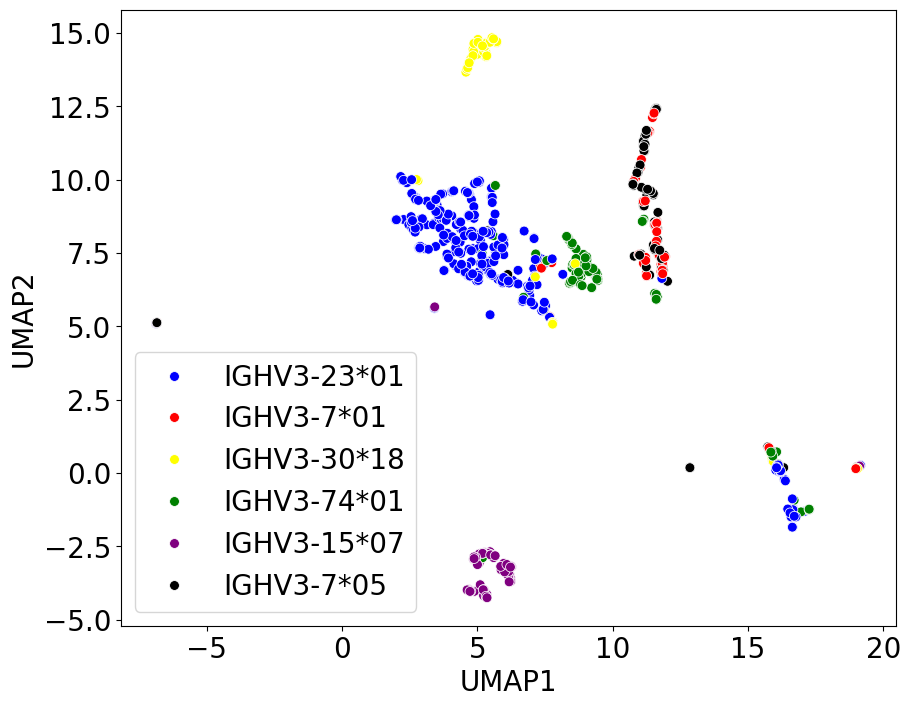

In [173]:
reducer= umap.UMAP(n_neighbors=5, min_dist=0.01, metric='cosine')
umap_embeddings3 = reducer.fit_transform(average_embeddings)
umap_df = pd.DataFrame(umap_embeddings3, columns=['UMAP1', 'UMAP2'])
umap_df["V_FAM"] = df_v3["v_call"]
# umap_df['V_FAM'] = small_df["V_FAM"][2000:2250].values
plt.figure(figsize=(10, 8))
sns.scatterplot(data=umap_df, x='UMAP1', y='UMAP2', hue='V_FAM', palette=["blue","red","yellow","green","purple","black"], s=50)
# sns.scatterplot(data=umap_df, x='UMAP1', y='UMAP2',palette='Spectral', s=50)
plt.xlabel('UMAP1',fontsize=20)
plt.ylabel('UMAP2',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend( fontsize=20)
plt.show()


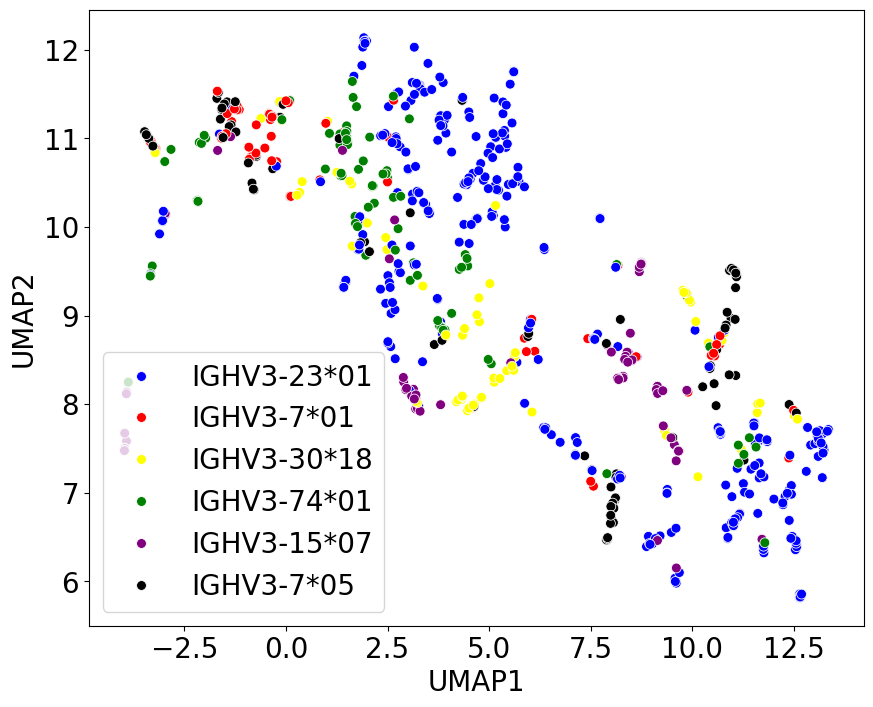

In [182]:
f_reducer= umap.UMAP(n_neighbors=5, min_dist=0.001, metric='cosine')
f_umap_embeddings3 = reducer.fit_transform(f_average_embeddings)
f_umap_df = pd.DataFrame(f_umap_embeddings3, columns=['UMAP1', 'UMAP2'])
f_umap_df["V_FAM"] = df_v3["v_call"]
# umap_df['V_FAM'] = small_df["V_FAM"][2000:2250].values
plt.figure(figsize=(10, 8))
sns.scatterplot(data=f_umap_df, x='UMAP1', y='UMAP2', hue='V_FAM', palette=["blue","red","yellow","green","purple","black"], s=50)
# sns.scatterplot(data=umap_df, x='UMAP1', y='UMAP2',palette='Spectral', s=50)
plt.xlabel('UMAP1',fontsize=20)
plt.ylabel('UMAP2',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend( fontsize=20)
plt.show()


# BLOSUM

## Blosum VS token embedding

In [342]:
model_size = "large"
model[model_size].eval()
token_embeddings = model[model_size].roberta.embeddings.word_embeddings.weight.data.cpu().numpy()


# token_embeddings = token_embeddings / np.linalg.norm(token_embeddings, axis=1)[:, None]
token_embeddings.shape

(25, 768)

In [343]:
amino_acids = ["A", "C", "D", "E", "F", "G", "H", "I", "K", "L", "M", "N", "P", "Q", "R", "S", "T", "V", "W", "Y"]

embedding_dict = {aa: token_embeddings[i+5] for i, aa in enumerate(amino_acids)}
embedding_dict.keys()

dict_keys(['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y'])

In [377]:
# Compare the embedding similarity with BLOSUM scores
def evaluate_embedding_similarity(embedding_dict, blosum_matrix):
    similarities = []
    for aa1 in embedding_dict:
        for aa2 in embedding_dict:
            if True:
                embedding_similarity = 1 -cosine(embedding_dict[aa1], embedding_dict[aa2])
                blosum_score = blosum_matrix[aa1][aa2]
                similarities.append((embedding_similarity, blosum_score))
    return similarities

# Evaluate
blosum62 = bl.BLOSUM(62)
similarities = evaluate_embedding_similarity(embedding_dict, blosum62)
similarities = np.array(similarities)
similarities.shape

(400, 2)

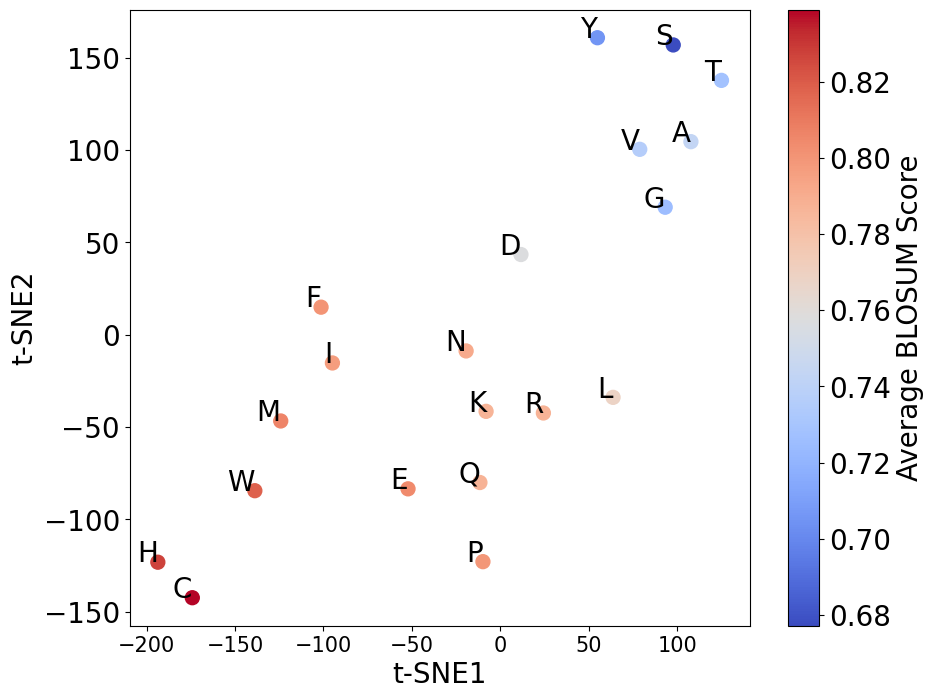

In [376]:

embedding_similarities = similarities[:, 1]
blosum_scores = similarities[:, 0]
# Assuming blosum_scores is already averaged for the 20 amino acids
amino_acids = ["A", "C", "D", "E", "F", "G", "H", "I", "K", "L", "M", "N", "P", "Q", "R", "S", "T", "V", "W", "Y"]
average_blosum_scores = np.mean(blosum_scores.reshape(20,20), axis=0)
# Apply t-SNE
tsne_results = TSNE(n_components=2, perplexity=4,n_iter=300000).fit_transform(token_embeddings[5:])
umap_results = umap.UMAP(n_neighbors=5, min_dist=0.01, metric='cosine').fit_transform(token_embeddings[5:])

plt.figure(figsize=(10, 8))
# Plot the t-SNE results with average BLOSUM scores as color
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=average_blosum_scores, cmap='coolwarm',s=100)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=20)
cbar.set_label(label='Average BLOSUM Score', fontsize=20)

# Label each point with its corresponding amino acid
for i, amino_acid in enumerate(amino_acids):
    plt.text(tsne_results[i, 0], tsne_results[i, 1], amino_acid, fontsize=20, ha='right')

plt.xlabel('t-SNE1', fontsize=20)
plt.ylabel('t-SNE2', fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=15)
plt.show()


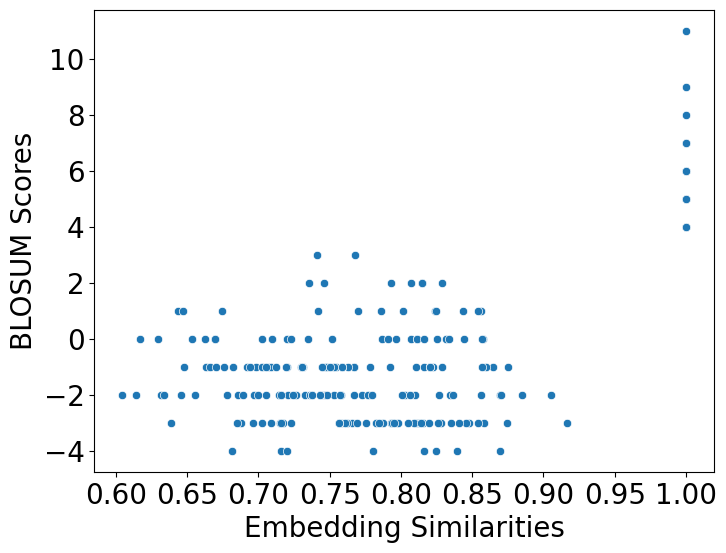

Pearson correlation coefficient: 0.585


In [385]:
def evaluate_embedding_similarity(embedding_dict, blosum_matrix):
    similarities = []
    aa_keys = list(embedding_dict.keys())
    for i in range(20):
        for j in range(i, 20):  # Only compute upper triangle
            aa1, aa2 = aa_keys[i], aa_keys[j]
            embedding_similarity = 1 - cosine(embedding_dict[aa1], embedding_dict[aa2])
            blosum_score = blosum_matrix[aa1][aa2]
            similarities.append((embedding_similarity, blosum_score))
    return similarities

# Evaluate
blosum62 = bl.BLOSUM(62)
similarities = evaluate_embedding_similarity(embedding_dict, blosum62)
similarities = np.array(similarities)

# Separate the similarity scores and BLOSUM scores
embedding_similarities = similarities[:, 0]
blosum_scores = similarities[:, 1]

# Calculate Pearson correlation
pearson_corr, p_value = pearsonr(embedding_similarities, blosum_scores)

# Plot the correlation
plt.figure(figsize=(8, 6))
sns.scatterplot(x=embedding_similarities, y=blosum_scores)
plt.xlabel('Embedding Similarities', fontsize=20)
plt.ylabel('BLOSUM Scores',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

print(f"Pearson correlation coefficient: {pearson_corr:.3f}")


